<a href="https://colab.research.google.com/github/Tee-Sarun/DADS7202_Deep_Learning/blob/main/MLP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Prepare the environment

In [ ]:
# List all NVIDIA GPUs as available in this computer (or Colab's session)
!nvidia-smi -L

GPU 0: NVIDIA H100 80GB HBM3 (UUID: GPU-3a61c64e-4236-3fee-54aa-2477d9858fe5)


In [ ]:
import sys
print( f"Python {sys.version}\n" )

import random
import time

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib.pyplot as plt
%matplotlib inline

import torch
print( f"PyTorch {torch.__version__}" )

# Get all available accelerators such as CUDA, MPS, MTIA, or XPU
num_accelerators = torch.accelerator.device_count()

if (num_accelerators <= 0):
    print("|- No hardware accelerators found. Using CPU only.")
else:
    print(f"|- PyTorch detected {num_accelerators} hardware accelerator(s)")
    print(f"|- PyTorch detected '{torch.accelerator.current_accelerator().type.upper()}' as the current accelerator")

    # Check cuda availability
    if torch.cuda.is_available():
        num_gpus = torch.cuda.device_count()
        print(f"|- PyTorch detected {num_gpus} CUDA GPU(s):")
    for i in range(num_gpus):
        print(f"   |- CUDA GPU {i}: {torch.cuda.get_device_name(i)}")

Python 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]

NumPy 2.0.2

PyTorch 2.9.0+cu126
|- PyTorch detected 1 hardware accelerator(s)
|- PyTorch detected 'CUDA' as the current accelerator
|- PyTorch detected 1 CUDA GPU(s):
   |- CUDA GPU 0: NVIDIA H100 80GB HBM3


In [ ]:
# Reproducibility & Device Configuration
def set_seeds(seed=42):
    """Sets fixed seeds for reproducibility across all libraries."""
    random.seed(seed)     # Controls Python's built-in random numbers.
    np.random.seed(seed)  # Controls NumPy's random arrays.
    torch.manual_seed(seed)           # Controls CPU weight initialization.
    torch.cuda.manual_seed_all(seed)  # Controls GPU weight initialization.

    # Ensure deterministic behavior for some PyTorch operations
    torch.backends.cudnn.deterministic = True # Ensure the GPU doesn't use "fast but slightly random" algorithms for math
    torch.backends.cudnn.benchmark = False
    print(f"Seeds set to {seed} for reproducibility.")

set_seeds(42)

Seeds set to 42 for reproducibility.


In [ ]:
# Detect GPU (CUDA), Apple Silicon (MPS), or fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# 2. Prepare the data

Suppose that this example deals with the single-label multi-class classification problem where a single input is a 1D vector of shape (100,) and there are 10 predefined classes of output.

In [ ]:
input_dim = 100     # The number of features per one input
output_dim = 10     # The number of output classes

train_size_total = 10000    # train set + validation set
test_size = 2000            # test set

In [ ]:
# Data generated after seeding will now be deterministic
x_train = np.random.randn(train_size_total, input_dim)
y_train = np.random.randint(0, output_dim, train_size_total)
x_test = np.random.randn(test_size, input_dim)
y_test = np.random.randint(0, output_dim, test_size)

print( f"x_train.shape={x_train.shape} , x_train.dtype={x_train.dtype} , min(x_train)={np.min(x_train):.4f} , max(x_train)={np.max(x_train):.4f}" )
print( f"y_train.shape={y_train.shape} , y_train.dtype={y_train.dtype} , min(y_train)={np.min(y_train)} , max(y_train)={np.max(y_train)}" )
print( f"x_test.shape={x_test.shape} , x_test.dtype={x_test.dtype} , min(x_test)={np.min(x_test):.4f} , max(x_test)={np.max(x_test):.4f}" )
print( f"y_test.shape={y_test.shape} , y_test.dtype={y_test.dtype} , min(y_test)={np.min(y_test)} , max(y_test)={np.max(y_test)}" )

x_train.shape=(10000, 100) , x_train.dtype=float64 , min(x_train)=-4.8294 , max(x_train)=4.6789
y_train.shape=(10000,) , y_train.dtype=int64 , min(y_train)=0 , max(y_train)=9
x_test.shape=(2000, 100) , x_test.dtype=float64 , min(x_test)=-4.6444 , max(x_test)=4.5958
y_test.shape=(2000,) , y_test.dtype=int64 , min(y_test)=0 , max(y_test)=9


In [ ]:
# Data preprocessing

## Convert to tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

## Create the full training dataset
full_train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)

## Define split sizes (e.g., 80% train, 20% validation)
train_subset_size = int(0.8 * train_size_total)
val_subset_size = train_size_total - train_subset_size

## Use random_split to create subsets
train_dataset, val_dataset = torch.utils.data.random_split(full_train_dataset, [train_subset_size, val_subset_size])

## Create the final test dataset
test_dataset = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)

## Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# 3. Create the network architecture

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(MLP, self).__init__()
        self.network = torch.nn.Sequential(
            torch.nn.Linear(in_dim, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, out_dim)
        )

    def forward(self, x):
        return self.network(x)

In [ ]:
# CRITICAL: Move model to device (Initialization happens here, seeded)
model = MLP(input_dim, output_dim).to(device)

# CHECKING MODEL DEVICE
# - In PyTorch, models don't have a single .device attribute, but their parameters do.
model_device = next(model.parameters()).device
print(f"Model is currently on: {model_device}")

Model is currently on: cuda:0


In [ ]:
print("--- Model Text Summary ---")
print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total Trainable Parameters: {total_params:,}")

--- Model Text Summary ---
MLP(
  (network): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)
Total Trainable Parameters: 67,658


In [ ]:
# Monitor weights of the first layer
first_layer_weights = model.network[0].weight.data
print(first_layer_weights.shape)
print(first_layer_weights)

torch.Size([256, 100])
tensor([[-0.0178,  0.0541, -0.0831,  ...,  0.0235,  0.0822,  0.0888],
        [-0.0258,  0.0149, -0.0668,  ...,  0.0917,  0.0350, -0.0560],
        [ 0.0757,  0.0928, -0.0271,  ...,  0.0235,  0.0034,  0.0219],
        ...,
        [-0.0803, -0.0172, -0.0612,  ..., -0.0426,  0.0862,  0.0860],
        [ 0.0911,  0.0837,  0.0984,  ..., -0.0170, -0.0685,  0.0313],
        [ 0.0730, -0.0859, -0.0973,  ...,  0.0104, -0.0383,  0.0473]],
       device='cuda:0')


# 4. Train the model

In [ ]:
# Training setup
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [ ]:
epochs = 10
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

In [ ]:
print("--- Starting Training ---")
for epoch in range(epochs):
    # Start timer for the epoch
    start_time = time.time()

    # --- TRAINING PHASE ---
    model.train()
    running_loss = 0.0  # Accumulates the loss value across all batches in the epoch
    correct = 0       # Tracks the number of correctly predicted samples
    total = 0         # Tracks the total number of samples processed in the epoch

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Multiply mean loss by batch size to get total loss for this batch
        running_loss += loss.item() * inputs.shape[0]

        # Get the predicted class using argmax
        predicted = torch.argmax(outputs, dim=1)

        # Update total samples and count how many predictions matched the labels
        total += labels.shape[0]
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / train_subset_size
    train_acc = 100 * correct / total

    # --- VALIDATION PHASE (Using val_loader) ---
    model.eval()
    v_loss = 0.0
    v_correct = 0
    v_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            v_loss += loss.item() * inputs.shape[0]
            predicted = torch.argmax(outputs, dim=1)
            v_total += labels.shape[0]
            v_correct += (predicted == labels).sum().item()

    valid_loss = v_loss / val_subset_size
    valid_acc = 100 * v_correct / v_total

    scheduler.step()

    # End timer for the epoch
    epoch_duration = time.time() - start_time

    history['train_loss'].append(train_loss)
    history['val_loss'].append(valid_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(valid_acc)

    # Print all metrics for the current epoch
    print(f"Epoch {epoch+1}/{epochs} ({epoch_duration:.2f}s) | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {valid_loss:.4f}, Val Acc: {valid_acc:.2f}%")

--- Starting Training ---
Epoch 1/10 (0.37s) | Train Loss: 2.3044, Train Acc: 9.70% | Val Loss: 2.3041, Val Acc: 9.70%
Epoch 2/10 (0.18s) | Train Loss: 2.2889, Train Acc: 13.41% | Val Loss: 2.3169, Val Acc: 10.40%
Epoch 3/10 (0.18s) | Train Loss: 2.2473, Train Acc: 17.46% | Val Loss: 2.3434, Val Acc: 9.40%
Epoch 4/10 (0.18s) | Train Loss: 2.1632, Train Acc: 21.89% | Val Loss: 2.4139, Val Acc: 8.80%
Epoch 5/10 (0.18s) | Train Loss: 2.0244, Train Acc: 29.20% | Val Loss: 2.4925, Val Acc: 8.80%
Epoch 6/10 (0.18s) | Train Loss: 1.8294, Train Acc: 38.35% | Val Loss: 2.6209, Val Acc: 9.15%
Epoch 7/10 (0.18s) | Train Loss: 1.6176, Train Acc: 47.30% | Val Loss: 2.7741, Val Acc: 9.75%
Epoch 8/10 (0.18s) | Train Loss: 1.4532, Train Acc: 53.35% | Val Loss: 2.8688, Val Acc: 9.45%
Epoch 9/10 (0.19s) | Train Loss: 1.3434, Train Acc: 57.80% | Val Loss: 2.9150, Val Acc: 10.00%
Epoch 10/10 (0.18s) | Train Loss: 1.2886, Train Acc: 60.23% | Val Loss: 2.9292, Val Acc: 9.75%


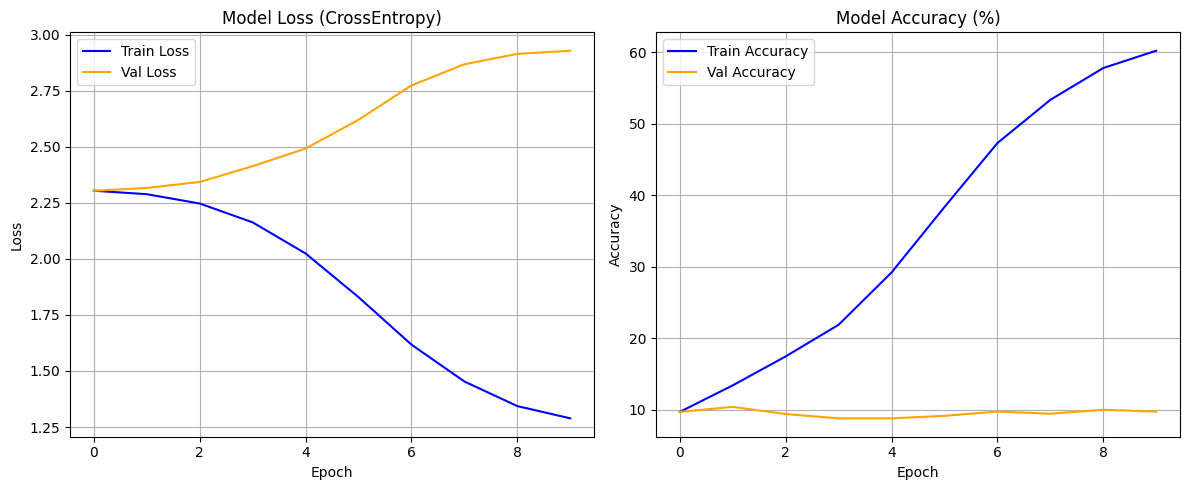

In [ ]:
# Plotting Results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss Plot
ax1.plot(history['train_loss'], label='Train Loss', color='blue')
ax1.plot(history['val_loss'], label='Val Loss', color='orange')
ax1.set_title('Model Loss (CrossEntropy)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Accuracy Plot
ax2.plot(history['train_acc'], label='Train Accuracy', color='blue')
ax2.plot(history['val_acc'], label='Val Accuracy', color='orange')
ax2.set_title('Model Accuracy (%)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# 5. Evaluate the model on test set

In [ ]:
model.eval()

print("--- Final Test Evaluation ---")
with torch.no_grad():
    test_outputs = model(x_test_tensor.to(device))
    test_preds = torch.argmax(test_outputs, dim=1)
    final_acc = (test_preds.cpu() == y_test_tensor).sum().item() / test_size
    print(f"Final Test Accuracy: {final_acc*100:.2f}%")

--- Final Test Evaluation ---
Final Test Accuracy: 9.35%


# 6. Inference

In [ ]:
single_example = x_test_tensor[0].unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    single_pred = model(single_example)
    predicted_class = torch.argmax(single_pred, dim=1).item()
    print(f"Single Example Prediction: Class {predicted_class} (True: {y_test_tensor[0].item()})")


Single Example Prediction: Class 6 (True: 7)


In [ ]:
batch_examples = x_test_tensor[:5].to(device)

with torch.no_grad():
    batch_preds = model(batch_examples)
    predicted_classes = torch.argmax(batch_preds, dim=1).cpu().numpy()
    print(f"Batch Predictions: {predicted_classes} (True: {y_test_tensor[:5].numpy()})")

Batch Predictions: [6 2 8 2 7] (True: [7 6 3 8 0])
